Imports 

In [140]:
import tensorflow as tf 
import os 
import numpy as np 
import PIL
import tensorflow_hub as hub
import matplotlib.pyplot as plt 
import random
import pandas as pd 
import matplotlib.style as style
import datetime 

from time import time
from glob import glob 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [141]:
print("TF version:", tf.__version__)

TF version: 2.4.0-dev20200803


Load training and validation images 

In [142]:
path = os.getcwd()
train_dir = os.path.join(path, 'MURA-v1.1/train')
val_dir = os.path.join(path, 'MURA-v1.1/valid')
test_dir = os.path.join(path, 'Sorted Anatomy')
print (train_dir, val_dir, test_dir)

/home/raven/workspace/anatomy_detection/MURA-v1.1/train /home/raven/workspace/anatomy_detection/MURA-v1.1/valid /home/raven/workspace/anatomy_detection/Sorted Anatomy


In [143]:
train_image_count = len(list(glob('%s/*/*.jpg' % train_dir)))
print ('# of training images:', train_image_count)

# of training images: 35520


In [144]:
val_image_count = len(list(glob('%s/*/*.jpg' % val_dir)))
print ('# of validation images:', val_image_count)

# of validation images: 3008


In [145]:
classes_count = len(glob('%s/*/' % train_dir))
print ('# of classes:', classes_count)

# of classes: 7


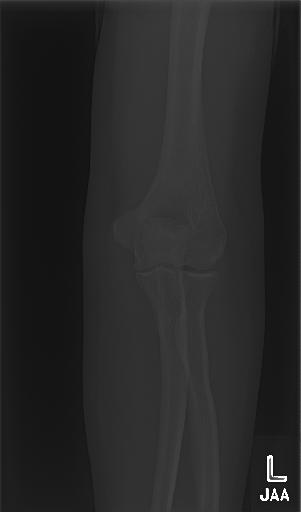

In [146]:
elbows = list(glob('%s/XR_ELBOW/*.jpg' % train_dir))

PIL.Image.open(str(elbows[0]))

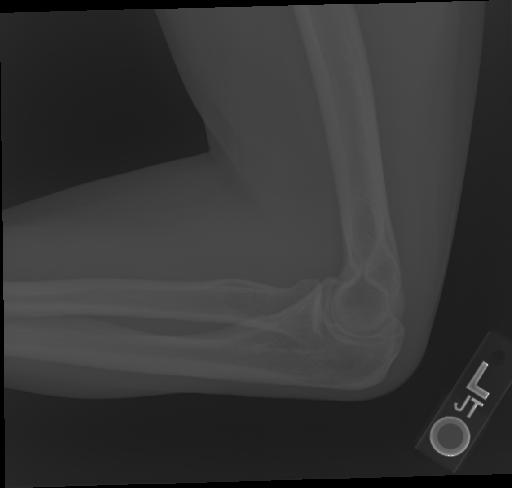

In [147]:
PIL.Image.open(str(elbows[1]))

In [148]:
BATCH_SIZE = 32
IMG_HEIGHT = 224 
IMG_WIDTH = 224

In [149]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    image_size=(IMG_WIDTH, IMG_HEIGHT),
    shuffle=True,
    seed=123,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
)

Found 35520 files belonging to 7 classes.


In [150]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    image_size=(IMG_WIDTH, IMG_HEIGHT),
    shuffle=True,
    seed=123,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
)

Found 3008 files belonging to 7 classes.


In [151]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    image_size=(IMG_WIDTH, IMG_HEIGHT),
    shuffle=True,
    seed=123,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
)

Found 76 files belonging to 7 classes.


In [152]:
class_names = train_ds.class_names
print(class_names)

['XR_ELBOW', 'XR_FINGER', 'XR_FOREARM', 'XR_HAND', 'XR_HUMERUS', 'XR_SHOULDER', 'XR_WRIST']


In [153]:
for f, l in train_ds.take(1):
    print("Shape of features array:", f.numpy().shape)
    print("Shape of labels array:", l.numpy().shape)

Shape of features array: (32, 224, 224, 3)
Shape of labels array: (32, 7)


Build the model

In [154]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255, name='normalization')

In [155]:
feature_extractor_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(IMG_WIDTH,IMG_HEIGHT,3))

In [156]:
feature_extractor_layer.trainable = False

In [157]:
data_augmentation_layer = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip(input_shape=(IMG_HEIGHT, IMG_WIDTH,3)),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
    tf.keras.layers.experimental.preprocessing.RandomContrast(0.2), 
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)
], name='data_augmentation')

In [158]:
def create_model(data_augmentation_layer, normalization_layer, feature_extractor_layer, classes_count):
    model = tf.keras.Sequential([
        data_augmentation_layer,
        normalization_layer,
        feature_extractor_layer,
        tf.keras.layers.Dense(512, activation='relu', name='hidden'),
        tf.keras.layers.Dense(classes_count, activation='sigmoid', name='output')
    ])
    
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy', 
                           tf.keras.metrics.Precision(), 
                           tf.keras.metrics.Recall()]
                 )
    return model

In [159]:
model = create_model(data_augmentation_layer, normalization_layer, feature_extractor_layer, classes_count)

In [160]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
data_augmentation (Sequentia (None, 224, 224, 3)       0         
_________________________________________________________________
normalization (Rescaling)    (None, 224, 224, 3)       0         
_________________________________________________________________
keras_layer_3 (KerasLayer)   (None, 2048)              23564800  
_________________________________________________________________
hidden (Dense)               (None, 512)               1049088   
_________________________________________________________________
output (Dense)               (None, 7)                 3591      
Total params: 24,617,479
Trainable params: 1,052,679
Non-trainable params: 23,564,800
_________________________________________________________________


Train the model or load a model

In [161]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [162]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [163]:
training = True

In [164]:
if training:  
    history = model.fit(
        train_ds,
        epochs=1,
        validation_data=val_ds,
        callbacks=[tensorboard_callback, 
                   EarlyStopping(patience=3),
                   ReduceLROnPlateau(factor=0.2, patience=5, verbose=1)]
    )
    model.save('saved_models/anatomy_model_'+ datetime.datetime.now().strftime("%Y%m%d-%H%M%S")) 
    
else: 
    model = tf.keras.models.load_model('saved_models/anatomy_model_512')

1110/1110 [==============================] - 215s 193ms/step - loss: 0.1390 - accuracy: 0.8271 - precision_3: 0.8573 - recall_3: 0.7687 - val_loss: 0.0934 - val_accuracy: 0.8873 - val_precision_3: 0.8980 - val_recall_3: 0.8634
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


INFO:tensorflow:Assets written to: saved_models/anatomy_model_20200807-153055/assets


INFO:tensorflow:Assets written to: saved_models/anatomy_model_20200807-153055/assets


Results

In [165]:
if training:
    %tensorboard --logdir logs/fit

In [166]:
loss, accuracy, precision, recall = model.evaluate(val_ds)

94/94 [==============================] - 15s 159ms/step - loss: 0.0934 - accuracy: 0.8873 - precision_3: 0.8980 - recall_3: 0.8634


In [167]:
print ('Validation Results\n\nLoss:{:.2f}\nAccuracy: {:.2f}\nPrecision: {:.2f}\nRecall: {:.2f}\n'.format(
    loss*100, accuracy*100, precision*100, recall*100))

Validation Results

Loss:9.34
Accuracy: 88.73
Precision: 89.80
Recall: 86.34



In [168]:
loss, accuracy, precision, recall = model.evaluate(test_ds)

3/3 [==============================] - 1s 303ms/step - loss: 0.4720 - accuracy: 0.2105 - precision_3: 0.2439 - recall_3: 0.1316


In [169]:
print ('Test Results\n\nLoss:{:.2f}\nAccuracy: {:.2f}\nPrecision: {:.2f}\nRecall: {:.2f}\n'.format(
    loss*100, accuracy*100, precision*100, recall*100))

Test Results

Loss:47.20
Accuracy: 21.05
Precision: 24.39
Recall: 13.16



In [ ]:
Visualize model predictions 

In [170]:
def show_prediction(img_paths, model, title):
    
    img_path = random.choice(img_paths)

    # Read and prepare image
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224,224,3))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)

    # Generate prediction
    prediction = (model.predict(img) > 0.5).astype('int')
    prediction = pd.Series(prediction[0])
    prediction.index = class_names
    prediction = prediction[prediction==1].index


    # Dispaly image with prediction
    style.use('default')
    plt.figure(figsize=(8,4))
    plt.imshow(PIL.Image.open(img_path))
    plt.title('\n\n{}\n\n\nPrediction\n{}\n'.format(title, list(prediction)), fontsize=9)
    plt.show()

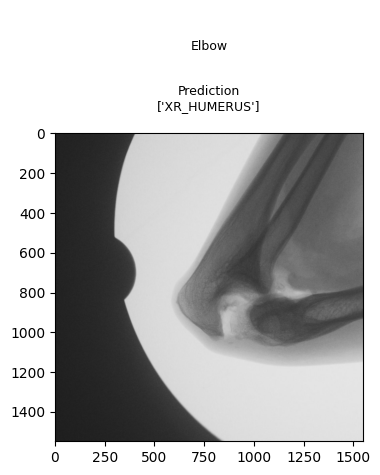

In [171]:
elbows = list(glob('%s/XR_ELBOW/*.jpg' % test_dir))
show_prediction(elbows, model, 'Elbow')

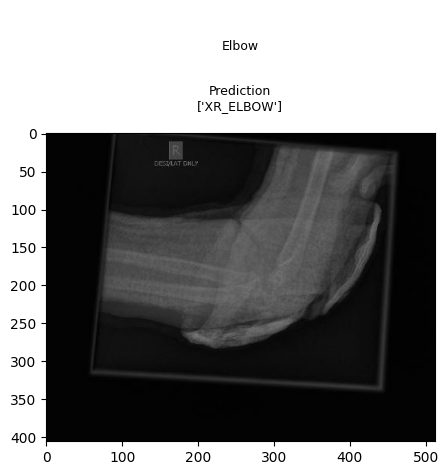

In [172]:
elbows = list(glob('%s/XR_ELBOW/*.jpg' % val_dir))
show_prediction(elbows, model, 'Elbow')

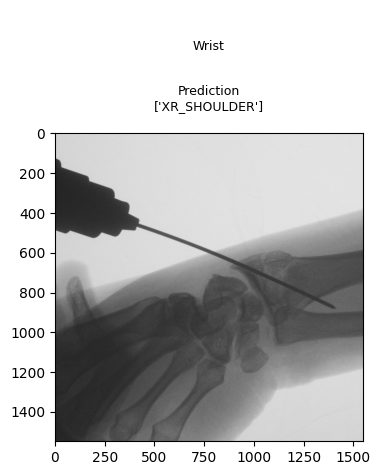

In [173]:
wrists = list(glob('%s/XR_WRIST/*.jpg' % test_dir))
show_prediction(wrists, model, 'Wrist')

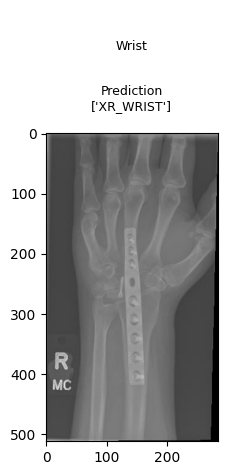

In [174]:
wrists = list(glob('%s/XR_WRIST/*.jpg' % val_dir))
show_prediction(wrists, model, 'Wrist')

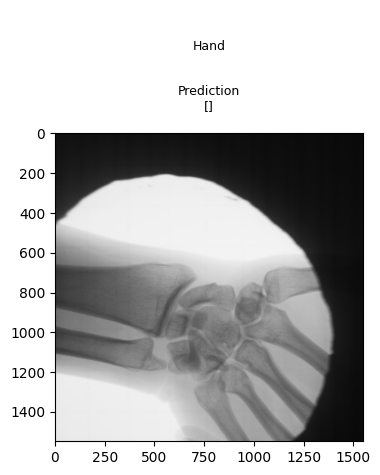

In [175]:
hands = list(glob('%s/XR_HAND/*.jpg' % test_dir))
show_prediction(hands, model, 'Hand')

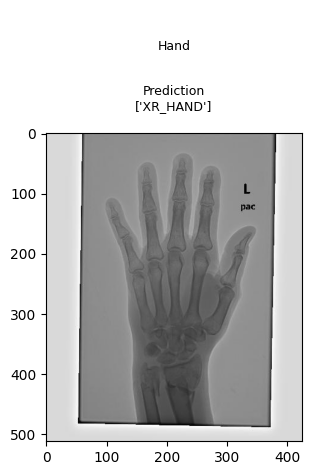

In [176]:
hands = list(glob('%s/XR_HAND/*.jpg' % val_dir))
show_prediction(hands, model, 'Hand')

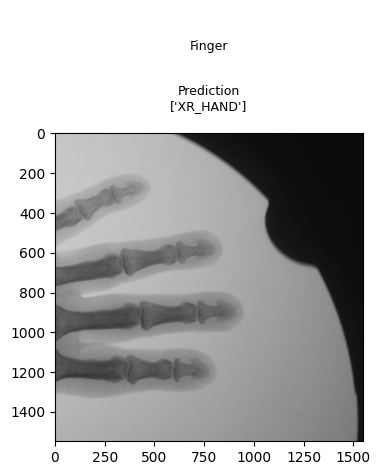

In [177]:
fingers = list(glob('%s/XR_FINGER/*.jpg' % test_dir))
show_prediction(fingers, model, 'Finger')

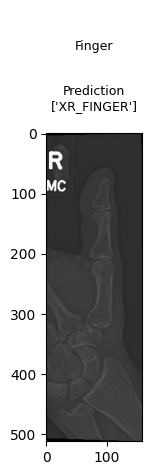

In [178]:
fingers = list(glob('%s/XR_FINGER/*.jpg' % val_dir))
show_prediction(fingers, model, 'Finger')

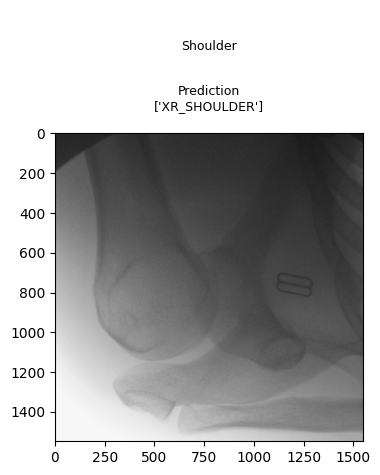

In [179]:
shoulders = list(glob('%s/XR_SHOULDER/*.jpg' % test_dir))
show_prediction(shoulders, model, 'Shoulder')

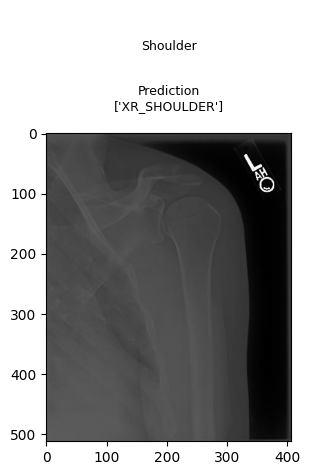

In [180]:
shoulders = list(glob('%s/XR_SHOULDER/*.jpg' % val_dir))
show_prediction(shoulders, model, 'Shoulder')

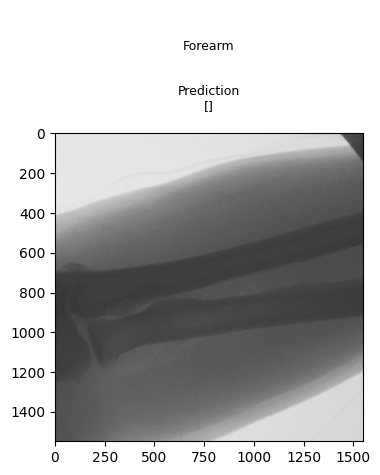

In [181]:
forearms = list(glob('%s/XR_FOREARM/*.jpg' % test_dir))
show_prediction(forearms, model, 'Forearm')

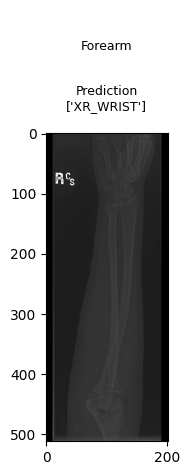

In [182]:
forearms = list(glob('%s/XR_FOREARM/*.jpg' % val_dir))
show_prediction(forearms, model, 'Forearm')